# 고용 기사를 활용한 KoBERT 긍부정 5단계 모델

### 활용데이터 : 통계청_인공지능 학습을 위한 고용기사 감성지수 라벨링 데이터

##### KoBERT를 활용하여 긍부정만 나눌 수 있는 모델(0,1)이 아닌, 긍부정을 5단계로 나누어 강한 부정, 부정, 중립, 긍정, 강한 긍정으로 나누었습니다. 라벨러1 ~ 라벨러6의 사람들이 남긴 점수를 평균 점수로 내 학습을 진행했으며, 데이터를 토대로 질문을 할 시 긍부정 5단계로 확인이 가능합니다.


## install

#### 필요한 라이브러리를 불러오기 위해 install을 진행합니다. 현재 2023.07.21을 기준으로 이 방식 외에 방식으로 install을 하게되면 오류가 발생하므로 똑같은 방식의 install을 진행해주시길 바랍니다.

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#### koBERT 모델은 현재 huggingface로 불러와야 colab에서 사용가능합니다. 이외의 다른 방식으로 불러오면 오류가 발생하니 hf로 불러주세요.

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master


In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-lntzpnat/kobert-tokenizer_94d4362b6a354148ac18717286f1a477
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-lntzpnat/kobert-tokenizer_94d4362b6a354148ac18717286f1a477
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


## import

#### 필요한 라이브러리를 import 해줍니다. gluonnlp에서 만약 오류가 발생한다면 pip install을 다른 버전으로 하시면 됩니다.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from gluonnlp.vocab import BERTVocab
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

In [ ]:
# ★ Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

#### 학습 형태를 GPU로 할당합니다.

In [ ]:
# for gpu setting
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

#### skt/kobert-base-v1 모델을 불러옵니다.

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
# vocab 객체 생성
vocab = BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


## Data

#### 데이터를 불러옵니다. 데이터는 공공 데이터 포털에 올라와 있는 데이터를 활용했으며 2018년부터 2020년 8월까지의 네이버 경제/ 사회면 속보성 기사중 고용관련 기사의 긍부정 강도를 나타낸 인공지능 학습용 데이터입니다.

https://www.data.go.kr/data/15075840/fileData.do

#### 데이터들은 따로 csv파일로 변환하여 합치는 과정을 진행하였습니다. 과정이 궁금하시면
https://colab.research.google.com/drive/18vFYsagKjnROHrDsZH3yro1CvoGRXxn1?usp=drive_link

#### 링크를 클릭하여 확인하시면 됩니다.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data/merged_news_title최종.csv')
data

,제목,라벨러1,라벨러2,라벨러3,라벨러4,라벨러5,라벨러6
0,"충남 청년 86%_ ""코로나19로 청년노동시장 악화됐다""",2,2,1,2,2,3
1,[단독] 일자리 절벽에 조선족 일자리 줄인다,2,3,1,2,2,3
2,"공공기관들 청년채용 못 채웠다 자리가 없어서 """,2,2,1,2,2,3
3,'코로나 쇼크' 기업 채용 위축 3월 구인 25% 급감,2,2,1,2,2,2
4,코로나19로 전세계 여행 관광업계 1억명 이상 일자리 잃어,2,2,1,2,2,2
...,...,...,...,...,...,...,...
7613,[밑줄쫙] 기업 채용계획 10년 만에 최저.. 내년 취업 더 어려워?,4,2,1,2,2,3
7614,2020년 국가공무원 공채로 6110명 선발,4,4,4,4,4,3
7615,올해 인턴사원 10명 중 7명은 정규직 전환,4,4,4,4,4,3
7616,올해 인턴 10명 중 7명 정규직 전환,4,4,4,4,4,3


#### data의 값을 치환할 때 0 ~ 4까지로 바꿔줍니다.

CUDA error: device-side assert triggred

#### 만약 이오류가 발생하면 GPU 디바이스 환경 설정 관련 오류인 것처럼 보이지만, 실제로는 입출력 차원(dimension)을 제대로 맞추지 않아서 발생하는 경우가 많다. 만약 1부터 시작하게 되면 입출력의 차원이 맞지 않아 오류가 발생합니다.

In [ ]:
def calculate_average_scores(input_file):
    df = pd.read_csv(input_file)
    df['평균 점수'] = df[['라벨러1', '라벨러2', '라벨러3', '라벨러4', '라벨러5', '라벨러6']].mean(axis=1)
    df['평균 점수'] = df['평균 점수'].round().astype(int)
    return df

# 사용 예시
input_file = '/content/drive/MyDrive/data/merged_news_title최종.csv'  # 입력 CSV 파일 이름

data = calculate_average_scores(input_file)

# 값 치환을 수행합니다.
data.loc[data['평균 점수'] == 1, '평균 점수'] = 0
data.loc[data['평균 점수'] == 2, '평균 점수'] = 1
data.loc[data['평균 점수'] == 3, '평균 점수'] = 2
data.loc[data['평균 점수'] == 4, '평균 점수'] = 3
data.loc[data['평균 점수'] == 5, '평균 점수'] = 4
# 평균 점수가 계산된 DataFrame 출력
data

,제목,라벨러1,라벨러2,라벨러3,라벨러4,라벨러5,라벨러6,평균 점수
0,"충남 청년 86%_ ""코로나19로 청년노동시장 악화됐다""",2,2,1,2,2,3,1
1,[단독] 일자리 절벽에 조선족 일자리 줄인다,2,3,1,2,2,3,1
2,"공공기관들 청년채용 못 채웠다 자리가 없어서 """,2,2,1,2,2,3,1
3,'코로나 쇼크' 기업 채용 위축 3월 구인 25% 급감,2,2,1,2,2,2,1
4,코로나19로 전세계 여행 관광업계 1억명 이상 일자리 잃어,2,2,1,2,2,2,1
...,...,...,...,...,...,...,...,...
7613,[밑줄쫙] 기업 채용계획 10년 만에 최저.. 내년 취업 더 어려워?,4,2,1,2,2,3,1
7614,2020년 국가공무원 공채로 6110명 선발,4,4,4,4,4,3,3
7615,올해 인턴사원 10명 중 7명은 정규직 전환,4,4,4,4,4,3,3
7616,올해 인턴 10명 중 7명 정규직 전환,4,4,4,4,4,3,3


In [ ]:
data_list = []

for title, label in zip(data['제목'], data['평균 점수']):
  data = []
  data.append(title)
  data.append(str(label))

  data_list.append(data)

len(data_list)

7618

In [ ]:
data_list[:5]

[['충남 청년 86%_ "코로나19로 청년노동시장 악화됐다"', '1'],
 ['[단독] 일자리 절벽에 조선족 일자리 줄인다', '1'],
 ['공공기관들 청년채용 못 채웠다 자리가 없어서 "', '1'],
 ["'코로나 쇼크' 기업 채용 위축 3월 구인 25% 급감", '1'],
 ['코로나19로 전세계 여행 관광업계 1억명 이상 일자리 잃어', '1']]

#### 데이터 막대 그래프를 생성합니다. 데이터의 분포가 적절한지 확인 후 학습을 진행하는 과정을 거칩니다. 0, 4점의 데이터가 부족하지만, 1, 3 의 부정 긍정 개수가 매우 비슷하게 형성되어 있으며 중립의 데이터도 적당히 존재하므로 학습데이터로는 충분합니다.

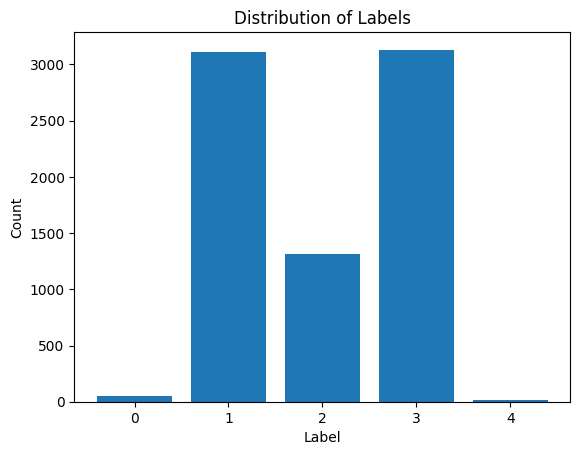

0점: 49개
1점: 3110개
2점: 1314개
3점: 3131개
4점: 14개


In [ ]:
import matplotlib.pyplot as plt

#각 라벨의 개수 계산
counts = [sum(1 for item in data_list if item[1] == label) for label in ['0', '1', '2', '3', '4']]

#막대 그래프 생성
labels = ['0', '1', '2', '3', '4']
plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

# 각 라벨의 개수 출력
for label, count in zip(labels, counts):
  print(f'{label}점: {count}개')

## 학습 데이터 분리

#### trainset, testset을 분리합니다. 분리는 4:1 비율로 진행하였습니다.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_list, test_size = 0.2, shuffle=True, random_state = 0)

In [ ]:
print(len(train))
print(len(test))

6094
1524


## Parameters Setting

#### 파라미터를 세팅합니다. 여기서 다른것은 별로 안건들이는게 좋고 변경하실거면 배치 사이즈나 에폭값만 변경하여 학습을 진행하시는게 좋습니다.

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

## BERTDataset (매우 중요!)

#### 아래에 있는 class들을 실행하지 않고 바로 BERTDataset을 실행할 시 오류가 지속적으로 발생한다. 이러한 오류를 고치기위해 def __init__에서 input에 vocab를 받는 부분 추가, self._vocab = vocab 을 추가하고, def __call__에서 vocab=self._vocab로 바꿔줬다. + convert 함수에서 tokens_a = self._tokenizer.tokenize(text_a)로 바꿔줘야 잘 훈련이 됩니다.

[출처] No module named 'kobert' 에러 해결|작성자 yeon
##### 진심으로 감사합니다 yeon님 님 덕분에 살았어요....



In [ ]:
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')



In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


####  Dataset을 인스턴스 변환

In [ ]:
# train 데이터셋을 BERTDataset 클래스의 인스턴스로 변환
data_train = BERTDataset(train, 0, 1, tokenizer, vocab, max_len, True, False)

# test 데이터셋을 BERTDataset 클래스의 인스턴스로 변환
data_test = BERTDataset(test, 0, 1, tokenizer, vocab, max_len, True, False)


In [ ]:
data_train[0]

(array([   2, 2124,  518, 7431, 6983, 5808, 6896, 2350,  520, 7126, 7159,
        6817, 7221, 7678,   15, 1120,  903, 7804,    8,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(20, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 2)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## BERTClassifier

이 과정에서는 `num_classes`에 집중하면 된다. 내가 만약 분류하는게 2개면 `num_classes`를 2로 이런식으로 변경하면된다. 내가 사용하는 클래스의 개수는 5이므로 5로 설정해두었다.

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
train_dataloader

## train

이제 학습을 진행하는 과정이다. epoch값을 10으로 두어 약 30분만에 끝났다. 그래도 데이터가 적어서 그런지 엄청 빠르게 끝난 것 같다. `test`를 진행해도 약 80%가 맞는 것을 확인할 수 있다.

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-29-c43874aa7363>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.7409043312072754 train acc 0.109375
epoch 1 train acc 0.6074451264880952


<ipython-input-29-c43874aa7363>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 1 test acc 0.763671875


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.7022015452384949 train acc 0.75
epoch 2 train acc 0.7891090029761906


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 2 test acc 0.7771935096153846


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.6391881108283997 train acc 0.765625
epoch 3 train acc 0.8434012276785715


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 3 test acc 0.796875


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5089163780212402 train acc 0.859375
epoch 4 train acc 0.88134765625


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 4 test acc 0.8007311698717948


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.35815510153770447 train acc 0.859375
epoch 5 train acc 0.92236328125


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 5 test acc 0.7952223557692308


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.17831294238567352 train acc 0.953125
epoch 6 train acc 0.9441731770833334


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 6 test acc 0.7966245993589743


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.12773719429969788 train acc 0.96875
epoch 7 train acc 0.9689127604166666


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 7 test acc 0.7959735576923076


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.09220092743635178 train acc 0.984375
epoch 8 train acc 0.9814453125


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 8 test acc 0.8055889423076924


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.06507880240678787 train acc 0.984375
epoch 9 train acc 0.990234375


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 9 test acc 0.8041366185897436


  0%|          | 0/96 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.03595636039972305 train acc 0.984375
epoch 10 train acc 0.9920247395833334


  0%|          | 0/24 [00:00<?, ?it/s]

epoch 10 test acc 0.8021834935897436


## model save

#### 학습된 모델을 저장해줍니다.

In [ ]:
PATH = '/content/drive/MyDrive/'
torch.save(model.state_dict(), PATH + 'koBERT04.pt')

tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/koBERT04.pt"))

<All keys matched successfully>

In [ ]:
category = {'강한 부정': 0, '부정': 1, '중립': 2, '긍정': 3, '강한 긍정': 4}

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/koBERT04.pt'))
model.eval()

# 예측 실행
out = model(token_ids, valid_length, segment_ids)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# prediction

모델이 잘 학습이 되었는지 예측을 진행해본다. `predict_sentence`에 문장을 입력하면 0~5까지 가장 높은 점수를 갖는 인덱스가 값을 갖는 방식이다.

In [ ]:
# 예측하려는 문장
predict_sentence = '최저임금 1만원 무산됐지만…재계 "동결했어야…고용축소 우려""'

# BERTDataset 클래스의 인스턴스 생성
data = [predict_sentence, '0']
dataset_another = [data]
another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)

# DataLoader 클래스의 인스턴스 생성
test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

# 예측 실행
model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)


In [ ]:
out

tensor([[-1.0574,  5.7579,  0.5132, -3.0017, -2.1434]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
# 가장 높은 점수의 인덱스 계산
predicted_index = out.argmax()

# 예측 결과 출력
print(f'Predicted class: {predicted_index + 1}')


Predicted class: 2


## prediction2

#### 사용자에게 기사 제목을 입력 받으면 예측을 진행하는 알고리즘을 작성했다.

In [ ]:
while True:
    # 사용자로부터 입력 받기
    predict_sentence = input('Enter a sentence (or "quit" to exit): ')

    # 종료 조건 확인
    if predict_sentence == 'quit':
        break

    # BERTDataset 클래스의 인스턴스 생성
    data = [predict_sentence, '0']
    dataset_another = [data]
    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)

    # DataLoader 클래스의 인스턴스 생성
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    # 예측 실행
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # 가장 높은 점수의 인덱스 계산
        predicted_index  = out.argmax() + 1

        # 예측 결과 출력
        print(f'Predicted class: {predicted_index}')


Enter a sentence (or "quit" to exit): 최저임금 1만원 무산됐지만…재계 "동결했어야…고용축소 우려"
Predicted class: 2
Enter a sentence (or "quit" to exit): 김영선 "청년고용의무제 적용기간 2025년까지 늘려야"···청년고용촉진 특별법 개정안 발의
Predicted class: 3
Enter a sentence (or "quit" to exit): 고용노동부 장관, 사흘 연속 폭우·폭염 현장점검…"생명·안전 최우선"
Predicted class: 3
Enter a sentence (or "quit" to exit): 추경호 "소부장 특화단지 5개 추가 지정한다…수출·생산·고용 모두 늘어"
Predicted class: 4
Enter a sentence (or "quit" to exit): quit


# 후기

사실 NLP모델은 T5, koBERT밖에 만져보지 못했다. 회사에서 처음으로 NLP를 만져봐서 그런지 아직 어색한 부분이 많다. 어디가 필요없고 어디가 필요한지도 잘모르겠고 이미 올라온 코드들을 따라할 뿐이지 제대로 학습되고 진행되는지도 모르겠다. 그래도 열심히 해서 나 자신을 바꾸고 싶다.